In [1]:
! kaggle datasets download -d "sorour/95cloud-cloud-segmentation-on-satellite-images"

/bin/bash: line 1: kaggle: command not found


In [ ]:
! unzip '95cloud-cloud-segmentation-on-satellite-images.zip'

Archive:  95cloud-cloud-segmentation-on-satellite-images.zip
replace 38-Cloud_95-Cloud_Test_Metadata_Files/38-Cloud_95-Cloud_Test_Metadata_Files/LC08_L1TP_003052_20160120_20170405_01_T1_MTL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
pip install -r requirements.txt

In [1]:
import numpy as np
print(np.__version__)

1.26.4


In [2]:
pip install fastai

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import fastai
print(fastai.__version__)

2.2.2+cu121
True
2.7.19


In [3]:
from fastai.vision.all import *

In [4]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [5]:
def open_tif(fn, chnls=None, cls=torch.Tensor):
    im = (np.array(Image.open(fn))).astype('float32')
    return cls(im)

In [6]:
# Проверка функции
base_path = Path('./95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud')

open_tif(base_path/'red_patch_100_5_by_16_LC08_L1TP_035031_20160120_20170224_01_T1.TIF').shape

torch.Size([384, 384])

In [7]:
# Можем передать желаемый выходной класс, и он будет приведен в действие автоматически.
# Здесь получаем TensorImage
open_tif(base_path/'red_patch_100_5_by_16_LC08_L1TP_035031_20160120_20170224_01_T1.TIF', cls=TensorImage)

TensorImage([[26224., 26184., 26087.,  ..., 23974., 24023., 24763.],
             [26455., 26481., 26500.,  ..., 23410., 23957., 25184.],
             [26706., 26747., 26725.,  ..., 22721., 23341., 24194.],
             ...,
             [20343., 19618., 20201.,  ..., 21613., 21912., 21998.],
             [20530., 19543., 19815.,  ..., 21715., 21803., 21937.],
             [22067., 20237., 20074.,  ..., 21824., 21461., 21460.]])

<Axes: >

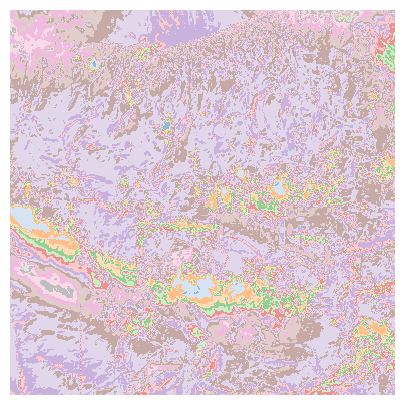

In [8]:
# Можем привести к нужному классу неявно или явно
mask = TensorMask(open_tif(base_path/'red_patch_100_5_by_16_LC08_L1TP_035031_20160120_20170224_01_T1.TIF', cls=TensorImage))
mask.show()

In [9]:
items = get_files(base_path, extensions='.TIF')
items

(#26301) [Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_193_9_by_17_LC08_L1TP_048019_20160420_20170223_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_343_17_by_7_LC08_L1TP_033036_20170804_20170812_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_65_3_by_17_LC08_L1TP_061009_20160720_20170223_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_90_5_by_10_LC08_L1TP_028036_20161220_20170218_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_131_6_by_16_LC08_L1TP_028001_20160611_20170324_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_56_3_by_14_LC08_L1TP_030033_20170815_20170825_01_T1.TIF'),Path('95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_p

In [10]:
# Функция map_filename упрощает отображение из одной папки в другую путем замены строк
def map_filename(base_fn, str1, str2):
    return Path(str(base_fn).replace(str1, str2))

def get_filenames(red_filename):
    return [red_filename,
            map_filename(red_filename, str1='red', str2='green'),
            map_filename(red_filename, str1='red', str2='blue'),
            map_filename(red_filename, str1='red', str2='nir'),
           ]

# функция open multispectral tif будет отвечать за открытие отдельных tiff-файлов и их сопоставление
def open_ms_tif(files):
    ms_img = None

    for path in files:
        img = open_tif(path)

        if ms_img is None:
            ms_img = img[None]
        else:
            ms_img = np.concatenate([ms_img, img[None]], axis=0)

    return TensorImage(ms_img)


# Проверка работает ли mapping корректно
for path in get_filenames(items[0]):
    assert path.exists() == True

# Проверка открытия изображений
open_ms_tif(get_filenames(items[0])).shape

torch.Size([4, 384, 384])

In [11]:
ImageBlock = TransformBlock(
    type_tfms = [get_filenames, open_ms_tif, lambda x: x/10000])

In [12]:
MaskBlock = TransformBlock(
    type_tfms = [partial(open_tif, cls=TensorMask), AddMaskCodes(codes=['clear', 'cloudy'])])

In [13]:
# в этом примере нам не нужно указывать функцию get_items
# потому что мы передадим список файлов в качестве источника
db = DataBlock(blocks=(ImageBlock, MaskBlock),
               get_y = partial(map_filename, str1='red', str2='gt'),
               splitter=RandomSplitter(valid_pct=0.2)
              )

# Мы вызовем db.summary, чтобы посмотреть, все ли идет хорошо
# окончательный образец состоит из кортежа (X, Y)
%time db.summary(source=items)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Setting up Pipeline: partial -> partial -> AddMaskCodes
Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: 

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (TensorImage of size 4x384x384, TensorMask of size 384x384)
    applying ToTensor gives
      (TensorImage of size 4x384x384, TensorMask of size 384x384)

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch

No batch_tfms to apply
CPU times: user 605 ms, sys: 50.6 ms, total: 655 ms
Wall time: 858 ms


In [14]:
dl = db.dataloaders(source=items, bs=8, num_workers=0)

# проверим был ли создан batch корректно
batch = dl.one_batch()
batch[0].shape, batch[1].shape

(torch.Size([8, 4, 384, 384]), torch.Size([8, 384, 384]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


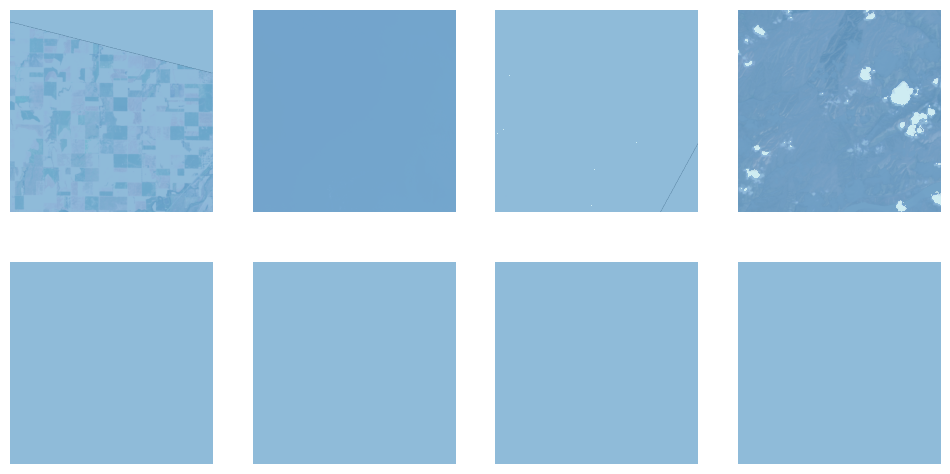

In [15]:
dl.show_batch(max_n=9)

In [16]:
def acc_metric(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def loss_fn(pred, targ):
    targ[targ==255] = 1
    return torch.nn.functional.cross_entropy(pred, targ.squeeze(1).type(torch.long))

learn_resnet34 = unet_learner(dl, resnet34, n_in=4, n_out=2, pretrained=False, loss_func=loss_fn, metrics=acc_metric)

SuggestedLRs(valley=0.00019054606673307717)

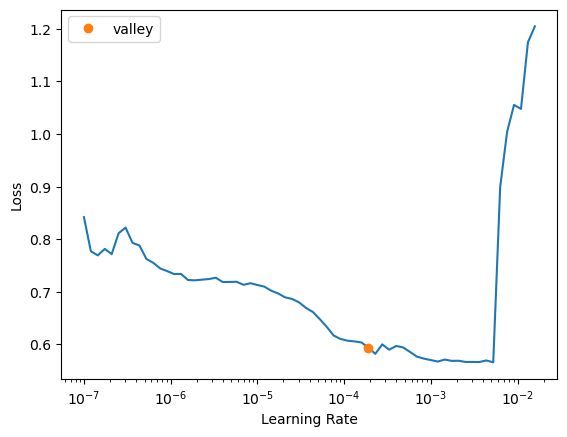

In [17]:
learn_resnet34.lr_find()

In [18]:
learn_resnet34.fit_one_cycle(10, lr_max=1e-4, wd=1e-2)

epoch,train_loss,valid_loss,acc_metric,time
0,0.245422,0.227763,0.892316,19:25
1,0.244194,0.260445,0.881066,19:23
2,0.230740,0.210189,0.912489,19:22
3,0.192596,0.293911,0.851903,19:22
4,0.161164,0.143860,0.943986,19:22
5,0.167662,0.133607,0.947222,19:22
6,0.142059,0.126307,0.950724,19:23
7,0.116895,0.111035,0.955280,19:23
8,0.105379,0.109050,0.955359,19:25
9,0.097849,0.100584,0.960092,19:25


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

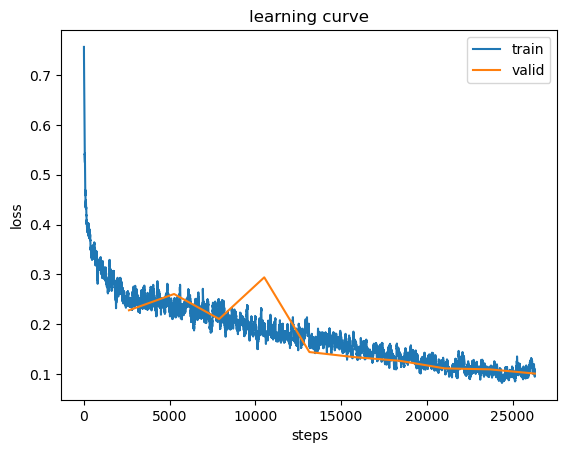

In [19]:
learn_resnet34.recorder.plot_loss()

In [20]:
# Сохраним модель
learn_resnet34.save('./resnet34-1.learner')

Path('models/resnet34-1.learner.pth')